In [79]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import gensim
import gensim.corpora as corpora
import gensim.models

import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'/mallet-2.0.8'})
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from pprint import pprint
import numpy as np

In [80]:
df = pd.read_csv('MP_RESULTS_text_cleaned.csv')
df = df.fillna('')

In [81]:
tokenized_words = [word_tokenize(i) for i in df['TEXT_cleaned']]

### Topic Modeling

In [82]:
# Create Dictionary
id2word = corpora.Dictionary(tokenized_words) #use entire corpus
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = tokenized_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [83]:
print(id2word)

Dictionary(8436 unique tokens: ['aca', 'aneurysm', 'centimeter', 'confirming', 'country']...)


In [84]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [85]:
limit=20; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=texts,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model


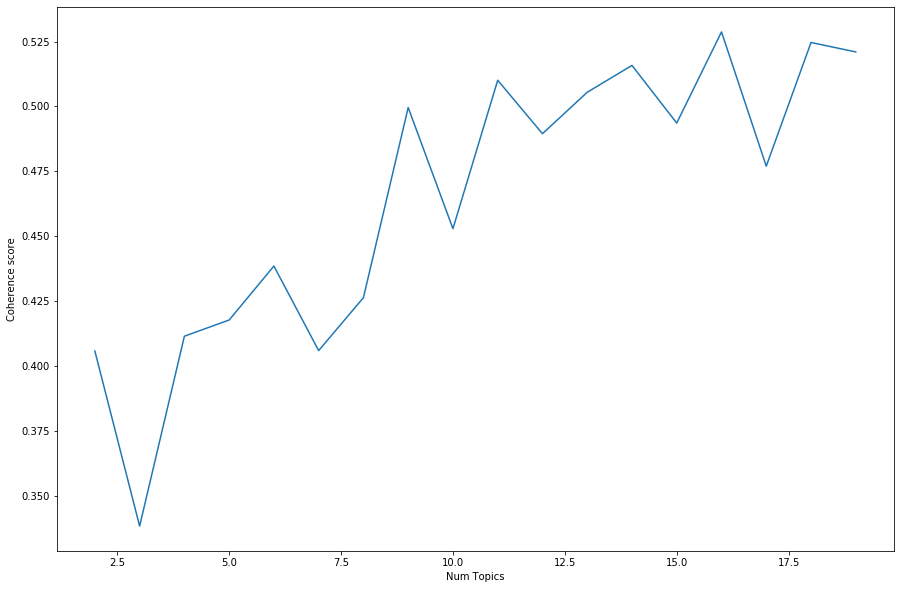

In [88]:
# show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [89]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.405754
Num Topics = 3  has Coherence Value of 0.338303
Num Topics = 4  has Coherence Value of 0.411469
Num Topics = 5  has Coherence Value of 0.417706
Num Topics = 6  has Coherence Value of 0.438498
Num Topics = 7  has Coherence Value of 0.405918
Num Topics = 8  has Coherence Value of 0.426325
Num Topics = 9  has Coherence Value of 0.499574
Num Topics = 10  has Coherence Value of 0.452901
Num Topics = 11  has Coherence Value of 0.510093
Num Topics = 12  has Coherence Value of 0.489494
Num Topics = 13  has Coherence Value of 0.505457
Num Topics = 14  has Coherence Value of 0.515804
Num Topics = 15  has Coherence Value of 0.493593
Num Topics = 16  has Coherence Value of 0.528712
Num Topics = 17  has Coherence Value of 0.47698
Num Topics = 18  has Coherence Value of 0.52464
Num Topics = 19  has Coherence Value of 0.520997


In [90]:
# Building LDA Model = LDA Model removing my_stop_words & featuring 30 topics
optimal_topics = 9
lda_model_optimal = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=optimal_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [91]:
pprint(lda_model_optimal.print_topics(num_topics=optimal_topics, num_words=15))
doc_lda = lda_model_optimal[corpus]

[(0,
  '0.021*"left" + 0.019*"right" + 0.017*"head" + 0.011*"fall" + '
  '0.010*"seizure" + 0.010*"headache" + 0.010*"she" + 0.009*"found" + '
  '0.008*"transferred" + 0.008*"intubated" + 0.007*"fracture" + '
  '0.007*"weakness" + 0.007*"eye" + 0.007*"pupil" + 0.007*"the"'),
 (1,
  '0.052*"the" + 0.025*"chest" + 0.023*"left" + 0.017*"history" + '
  '0.017*"artery" + 0.016*"disease" + 0.015*"right" + 0.013*"coronary" + '
  '0.013*"breath" + 0.013*"emergency" + 0.012*"pressure" + 0.012*"cardiac" + '
  '0.012*"shortness" + 0.011*"catheterization" + 0.009*"male"'),
 (2,
  '0.021*"denies" + 0.013*"non" + 0.012*"clear" + 0.011*"cough" + '
  '0.011*"breath" + 0.011*"fever" + 0.011*"report" + 0.010*"vitals" + '
  '0.010*"edema" + 0.010*"chest" + 0.010*"lung" + 0.010*"she" + 0.009*"bowel" '
  '+ 0.009*"sound" + 0.009*"abdomen"'),
 (3,
  '0.025*"intact" + 0.024*"extremity" + 0.019*"normal" + 0.014*"bilaterally" + '
  '0.014*"strength" + 0.013*"sensation" + 0.012*"noted" + 0.011*"skin" + '
  '0.0

In [92]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_optimal.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_optimal, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.287175729121408

Coherence Score:  0.5072511012652234


In [93]:
vector = lda_model_optimal[corpus]  # get topic probability distribution for a document

In [94]:
def Extract(vector):
    return [item[0] for item in vector]

In [95]:
vector_prob = Extract(vector)

In [96]:
vector_prob_df = pd.DataFrame(vector_prob, columns=list(range(0, optimal_topics)))
vector_prob_df.head()

,0,1,2,3,4,5,6,7,8
0,"(0, 0.19881175)","(1, 0.28986514)","(2, 0.04437517)","(4, 0.014975858)","(6, 0.091260925)","(7, 0.012850911)","(8, 0.33672154)",None,None
1,"(1, 0.58957386)","(2, 0.022926793)","(4, 0.062218398)","(6, 0.28090182)","(7, 0.010403747)","(8, 0.014460202)",None,None,None
2,"(0, 0.723557)","(1, 0.012137621)","(2, 0.06575628)","(4, 0.11448377)","(5, 0.025578173)","(6, 0.015718238)","(7, 0.013247718)","(8, 0.024928778)",None
3,"(0, 0.06371773)","(1, 0.013191864)","(2, 0.21357648)","(3, 0.29813907)","(4, 0.010922992)","(6, 0.10706317)","(7, 0.11335791)","(8, 0.17859294)",None
4,"(1, 0.42327404)","(4, 0.044625215)","(6, 0.048709806)","(7, 0.3152429)","(8, 0.14472544)",None,None,None,None


In [97]:
def clean_df(df):
    #Create empty dataframe copy
    df2 = pd.DataFrame(np.zeros(df.shape), columns = df.columns)
    nrows = df.shape[0]
    ncolumns = df.shape[1]
    #Populate empty dataframe
    for i in range(nrows):
        #Create key:value pair of each row
        rowdict = dict(zip([x[0] for x in df.iloc[i] if x != None], [x[1] for x in df.iloc[i] if x != None]))
        #Populate row based off of 
        for j in range(ncolumns):
            if j in rowdict.keys():
                df2.iloc[i][j] = rowdict[j]
            else:
                df2.iloc[i][j] = None
    return df2

In [98]:
vector_prob_df_align = clean_df(vector_prob_df)
vector_prob_df_align.head()

,0,1,2,3,4,5,6,7,8
0,0.198812,0.289865,0.044375,NaN,0.014976,NaN,0.091261,0.012851,0.336722
1,NaN,0.589574,0.022927,NaN,0.062218,NaN,0.280902,0.010404,0.014460
2,0.723557,0.012138,0.065756,NaN,0.114484,0.025578,0.015718,0.013248,0.024929
3,0.063718,0.013192,0.213576,0.298139,0.010923,NaN,0.107063,0.113358,0.178593
4,NaN,0.423274,NaN,NaN,0.044625,NaN,0.048710,0.315243,0.144725


In [99]:
topics = vector_prob_df_align
labels = df['hospital_expire_flag']

In [100]:
topic_modeling_results = pd.concat([labels, topics], axis=1)
topic_modeling_results = topic_modeling_results.fillna(0)

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [102]:
X = topic_modeling_results.drop(columns=['hospital_expire_flag'])
y = topic_modeling_results['hospital_expire_flag']

In [103]:
steps = [('under', RandomUnderSampler()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
rf = RandomForestClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)
score = scores.mean()
print('F1 Score: %.3f' % score)

F1 Score: 0.643


In [122]:
#No undersampling:
cv = KFold(n_splits=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})
y_pred_prob = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)
lr_auc = metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring = 'f1_micro')

In [123]:
print('Mortality Prediction, Topic modeling: No random undersampling')
print('AUC: ', lr_auc)
print('Bal. accuracy score:', scores.max())
print('Feature importance:')
print(feature_importances.sort_values(by='importance', ascending=False)[0:10])

Mortality Prediction, Topic modeling: No random undersampling
AUC:  0.6973732141490274
Bal. accuracy score: 0.8986995208761123
Feature importance:
  features  importance
7        7    0.163052
8        8    0.126491
2        2    0.126344
4        4    0.121626
1        1    0.114469
0        0    0.114414
3        3    0.105156
6        6    0.068516
5        5    0.059934


In [126]:
#Random undersampling
cv = KFold(n_splits=10)
steps = [('under', RandomUnderSampler()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
feature_importances_under = pd.DataFrame({'features': X.columns, 'importance': pipeline[1].feature_importances_})
y_pred_prob_under = pipeline.predict_proba(X_test)
y_pred_under = pipeline.predict(X_test)
lr_auc_under = metrics.roc_auc_score(y_test, y_pred_prob_under[:, 1])
scores_under = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring = 'f1_micro')

In [132]:
print('Mortality Prediction - Topic modeling: With random undersampling')
print('Topic model DF: ', topic_modeling_results.shape)
print('AUC: ', lr_auc_under)
print('F1 score:', scores_under.max())
print('Feature importance:')
print(feature_importances_under.sort_values(by='importance', ascending=False)[0:20])

Mortality Prediction - Topic modeling: With random undersampling
Topic model DF:  (48684, 10)
AUC:  0.7057009112678332
F1 score: 0.6673511293634496
Feature importance:
  features  importance
7        7    0.197421
2        2    0.119285
8        8    0.116634
4        4    0.115391
1        1    0.106382
0        0    0.105569
3        3    0.100216
6        6    0.078881
5        5    0.060221
